# **Machine Learning for Timeseries Prediction - A Primer for Eurac Research's Sustainable Heating and Cooling Group**

Authors: Thibault Marzullo and Gregor Henze

Revised: September 13, 2021

## **Introduction**

This notebook explores the application of several machine learning approaches to the problem of predicting 24-hour heating load profiles of a hydronic radiant heating system in a five-zone home, given 30 days of past measurements of external air temperature (Text) and global horizontal irradiation (GHI). The objective is to provide a high-level introduction to the application of these approaches.

The approaches presented here are, in order of appearance:

1. Regression trees:
 *   Single regression tree and tree pruning
 *   Tree bootstrap aggregation (bagging and random patches)
 *   Random forest
 *   Boosting

2. Multilinear regression:
 * Ordinary least squares
 * Least absolute shrinkage and selection operator (Lasso)

3. Support vector regression

**Note: Please create a local copy of this notebook on your Google account before using it**

First, mount your Google Drive to the Colab instance.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then, download the datasets from GitHub.

In [3]:
from os import path
if not path.exists("/content/drive/MyDrive/ML-for-Timeseries-prediction/EURAC_case5.csv"):
  !mkdir /content/drive/MyDrive/ML-for-Timeseries-prediction/
  !git clone https://github.com/henze-research-group/ML-for-Timeseries-prediction.git /content/drive/MyDrive/ML-for-Timeseries-prediction/

Cloning into '/content/drive/MyDrive/ML-for-Timeseries-prediction'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 0), reused 16 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.
Checking out files: 100% (8/8), done.


Next, we load required libraries including matplotlib, pandas, numpy, math, and scikit-learn.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn import tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance

Here, we define a few useful functions.

In [5]:
# Function for CVRMSE
def cvrmse(prediction, truth):
    prediction = [i for i in prediction if i!=0]
    truth = [i for i in truth if i!=0]
    return 100*math.sqrt(sum([(truth[i] - prediction[i])**2 for i in range(len(truth))])/len(truth))/(sum(truth)/len(truth))

# Function to truncate numbers
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

## **Pre-processing, part 1: formatting the data**

All datasets are provided with a 5-minute resolution. Three datasets are available, representing the same system with varying levels of modeling complexity.

1.   Case 5 (Test 20): Ideal heating loads without internal gains
2.   Case 6 (Test 23): Ideal heating loads with internal gains
3.   Case 7 (Test 32): Realistic heating loads with internal gains

In an effort to compare this method to Simone Buffa's method, the dataset will be filtered to contain hourly average data for two predictors only: external air temperature (Text) and global horizontal irradiance (GHI).

Additionally, this code generates new predictors for extracting:
* Hourly values for **past** 24 hours of GHI
* Hourly values for **past** 24 hours of Text

You can inspect the code below by clicking the arrow on the top left corner of this text box, and collapse it again for readability.



**Loading the data:**

In [8]:
case = 6

# Please "mount the drive folder", navigate to the datasets folder, and "copy path". 
# If you simply drag and drop the datasets in this notebook, they will be deleted at each reload.

if case == 5:
  filename = "/content/drive/MyDrive/ML-for-Timeseries-prediction/EURAC_case5.csv"
elif case == 6:
  filename = "/content/drive/MyDrive/ML-for-Timeseries-prediction/EURAC_case6.csv"
elif case == 7:
  filename = "/content/drive/MyDrive/ML-for-Timeseries-prediction/EURAC_case7.csv"
else:
  "Error: case does not exist."

# Maximum number of lags + 1
observations = 25

data = pd.read_csv(filename, delimiter=',')
data = pd.DataFrame(data)
data = data.drop(0) # The header is split across 2 rows, and Pandas only accepts the first. We drop the second row manually.

print("Original dataset")
print(data)

# Because the first row was a string, the entire dataset is imported in the wrong data type. This converts it back to float32.
for column in data.columns:
    data[column] = data[column].astype('float32')

FileNotFoundError: ignored

**Resampling data set:**

Resample the dataset from a 5-minute frequency (5T) to a 1-hour frequency (H) by computing the mean value of intermediate samples.
See [the usage of the .resample() method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html)
and
[the explanation for the 5T and H string objects used to set the frequency.](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

NOTE: Do not run this several times in a row, or the data frame will be resampled multiple times. Run block 50 again should this happen. 

In [7]:
data['DateTimeIndex'] = pd.date_range('2/1/2020', periods=len(data[data.columns[0]]), freq='5T') # Create datetime index
data.set_index('DateTimeIndex', inplace=True) # Replace the current dataframe index with the one just created. It makes it slightly easier to use the resample() method.
data = data.resample('H').mean() # Resample the data at a hourly frequency using the mean value
print(data)
# Note how the "TIME" column is averaged to the mean value of the decimal hour. This means that the value at time t is computed using the mean of the values between t and t + 1 hour. 

NameError: ignored

Extract data from the full dataset: Heating load, Text, GHI, and the time in hours since the beginning of the year.

In [ ]:
new = pd.DataFrame()
new['Qdot_0'] = data['Total heating load ']
new['Text_0'] = data['T_EXT']
new['GHI_0'] = data['IRR_HOR']
new['hour_year'] = data['TIME']

Add 24-hour window of past values as additional predictors.

In [ ]:
for i in range(1, observations):
    new['Text_-'+str(i)] = data['T_EXT'].shift(periods=i)
    new['GHI_-'+str(i)] = data['IRR_HOR'].shift(periods=i)
new = new.iloc[observations:] # Shifting columns generates 24 rows with missing values. This line drops these rows with missing data.

Save and inspect the new dataset:

In [ ]:
print("New dataset")
print(new)
data = new

## **Pre-processing, part 2: Preparing training and testing data**

This section splits the dataset into two portions: One for training the regression model, another for testing the model's prediction capabilities on unseen data. 

Two methods are shown in the code:
1. Using random samples extracted using sklearn's train_test_split method
2. Manually selecting a 30-day training and a 1-day testing dataset*

** This method is preferred to offer a fair comparison with Simone Buffa's approach. Unlike Simone Buffa, we are not retraining our methods after each new day with the latest 30 days, instead we train only on the first 30 days of data.*

You can inspect the code below by clicking the arrow on the top left corner of this text box and collapse it again for readability.


**Selecting the predictors and the predicted variable**

In [ ]:
# Select predicted variable

out = data['Qdot_0']

# Select predictors
# Text and GHI at t = t and at t = [t-1, t-23]
inp = data[['GHI_'+str(i) for i in range(-23, 1)]+['Text_'+str(i) for i in range(-23, 1)]]

**Extracting the testing and training datasets**

In [ ]:
# Select whether to randomize the samples or not

randomsamples = False

if randomsamples:

  X_train, X_test, y_train, y_test = train_test_split(inp, out, random_state=0, test_size = 0.3, train_size = 0.7) # Reserve 30% of the data for testing and 70% for training

else:

  step = 3600
  day = int(24 * 3600 / step)
  trainlen = day * 30
  testlen = day * 1
  start_day = day * 304 # The data starts on February 2nd, 2020. Day 304 is December 1st, 2020
  numdays = 10

  X_train = inp.iloc[start_day : start_day + trainlen]
  y_train = out.iloc[start_day : start_day + trainlen]
  # 1-day testing window
  X_test = inp.iloc[start_day + trainlen : start_day  + trainlen + testlen]
  y_test = out.iloc[start_day + trainlen : start_day + trainlen + testlen]
  # 10-day testing window for plots similar to Simone's
  X_test_m = inp.iloc[start_day + trainlen : start_day + trainlen + testlen * numdays]
  y_test_m = out.iloc[start_day + trainlen : start_day + trainlen + testlen * numdays]

  # Prepare plot labels:
  trainxlabels = [X_train.index[i].date() for i in range(len(X_train.index)) if i % 24 == 0]
  testxlabels = [X_test_m.index[i].date() for i in range(len(X_test_m.index)) if i % 24 == 0]

# **Regression Trees**
## **Approach 1: Single Regression Tree and Tree Pruning**

This section demonstrates the usage of regression trees for predicting the next 24 hours of heating and cooling load (Qdot), knowing the past 30 days of GHI, Text and Qdot.

This code uses Scikit's `DecisionTreeRegressor` method which is an improved CART method. Read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html?highlight=decision%20tree%20regressor#sklearn-tree-decisiontreeregressor).

Tree-based methods involve stratifying or segmenting the predictor space into a number of simple regions. In order to make a prediction for a given observation, we typically use the mean or the mode of the training observations in the region to which it belongs. Since the set of splitting rules used to segment the predictor space can be summarized in a tree, these types of approaches are known as decision tree methods. Tree-based methods are simple and useful for interpretation. However, they typically are not competitive with the best supervised learning approaches. Hence, we also introduce bagging, random forests, and boosting. Each of these approaches involves producing multiple trees, which are then combined to yield a single consensus prediction. We will see that combining a large number of trees can often result in an  improvement in prediction accuracy, at the expense of some loss in interpretation.


**Prediction via Stratification of the Feature Space**

We now discuss the process of building a regression tree. Roughly speaking, there are two steps.
1. We divide the predictor space, i.e., the set of possible values for $X_1, X_2, \ldots , X_p$ into $J$ distinct and non-overlapping regions, $R_1,R_2,\ldots ,R_J$.
2. For every observation that falls into the region $R_j$, we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$. For instance, suppose that in Step 1 we obtain two regions, $R_1$ and $R_2$, and that the response mean of the training observations in the first region is 10, while the response mean of the training observations in the second region is 20. Then for a given observation $X = x$, if $x \in R_1$ we will predict a value of 10, and if $x \in R_2$ we will predict a value of 20.

We now elaborate on Step 1 above. How do we construct the regions $R_1,\ldots,R_J$? In theory, the regions could have any shape. However, we choose to divide the predictor space into high-dimensional rectangles, or boxes, for simplicity and for ease of interpretation of the resulting predictive model. The goal is to find boxes $R_1, \ldots , R_J$ that minimize the residual sum of square ($RSS$), given by

\begin{equation}
  RSS = \sum_{j=1}^J \sum_{i \in R_j} (y_i-\hat{y}_{R_j})^2
\end{equation}


where $\hat{y}_{R_j}$ is the mean response for the training observations within the $j$-th box. Unfortunately, it is computationally infeasible to consider every possible partition of the feature space into $J$ boxes. For this reason, we take a top-down, greedy approach that is known as *recursive binary splitting*. The approach is top-down because it begins at the top of the tree(at which point all observations belong to a single region) and then successively splits the predictor space; each split is indicated via two new branches further down on the tree. It is greedy because at each step of the tree-building process, the best split is made at that particular step, rather than looking ahead and picking a split that will lead to a better tree in some future step.

In order to perform recursive binary splitting, we first select the predictor $X_j$ and the cutpoint $s$ such that splitting the predictor space into the regions $\{X|X_j < s\}$ and $\{X|X_j \geq s\}$ leads to the greatest possible reduction in RSS. (The notation $\{X|X_j < s\}$ means the region of predictor space in which $X_j$ takes on a value less than $s$.) That is, we consider all predictors $X_1, \ldots , X_p$, and all possible values of the cutpoint $s$ for each of the predictors, and then choose the predictor and cutpoint such that the resulting tree has the lowest $RSS$. 

Next, we repeat the process, looking for the best predictor and best cutpoint in order to split the data further so as to minimize the RSS within each of the resulting regions. However, this time, instead of splitting the entire predictor space, we split one of the two previously identified regions. We now have three regions. Again, we look to split one of these three regions further, so as to minimize the $RSS$. The process continues until a stopping criterion is reached; for instance, we may continue until no region contains more than five observations.

Once the regions $R_1,\ldots,R_J$ have been created, we predict the response for a given test observation using the mean of the training observations in the region to which that test observation belongs.


**Basic usage**

In [ ]:
# Define and fit a single regression tree with defined random seed for splitting consistency
clf_unpruned = DecisionTreeRegressor(random_state = 0).fit(X_train, y_train)

Plotting the training data and training prediction.

In [ ]:
# Predict training data using regression tree trained on the same data
prediction_unpruned_training = clf_unpruned.predict(X_train)

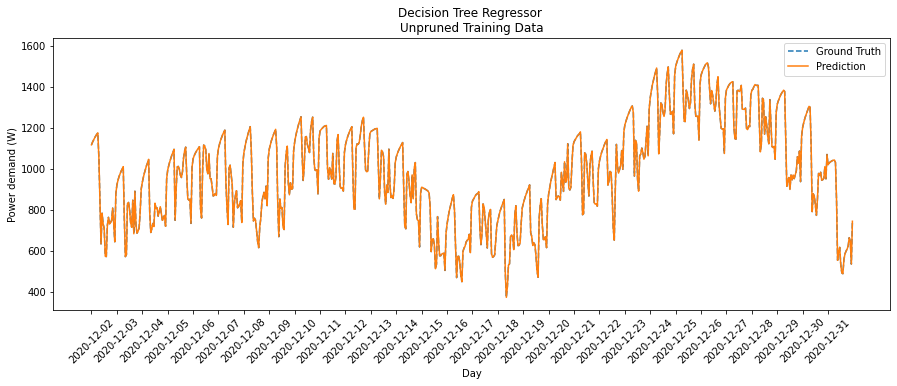

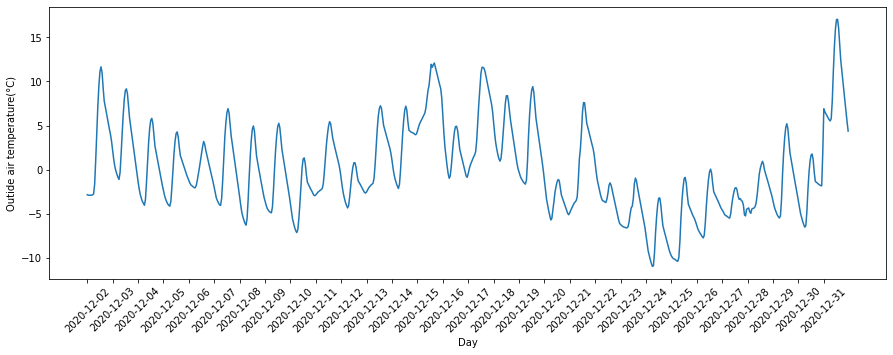

In [ ]:
# Plot prediction results
xaxis = np.arange(0,len(X_train),1)
plt.figure(figsize=(15,5))
plt.plot(xaxis, y_train,'--', xaxis,  prediction_unpruned_training)
plt.legend(('Ground Truth','Prediction'))
plt.title('Decision Tree Regressor \nUnpruned Training Data')
plt.xlabel("Day")
plt.ylabel("Power demand (W)")
plt.xticks(ticks=[i for i in range(len(xaxis)) if i%24==0], labels = trainxlabels, rotation = 45)
plt.show()
plt.figure(figsize=(15,5))
plt.xlabel("Day")
plt.ylabel("Outide air temperature(°C)")
plt.xticks(ticks=[i for i in range(len(xaxis)) if i%24==0], labels = trainxlabels, rotation = 45)
plt.plot(xaxis, X_train['Text_0'])
plt.show()

Plotting the testing data and testing prediction.

In [ ]:
# Predict testing data using regression tree trained on training data
prediction_unpruned = clf_unpruned.predict(X_test_m)

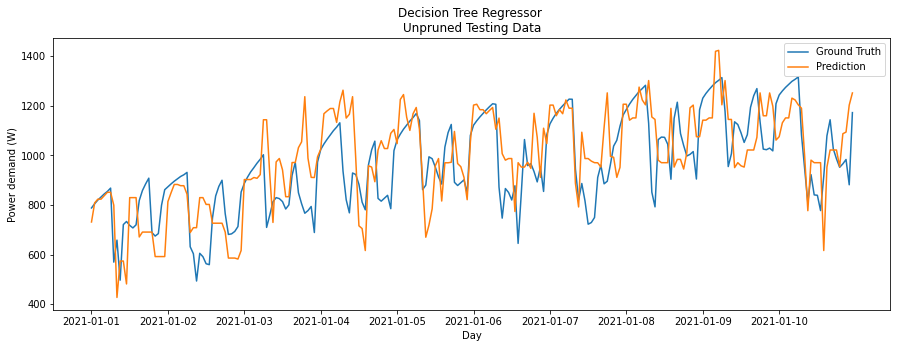

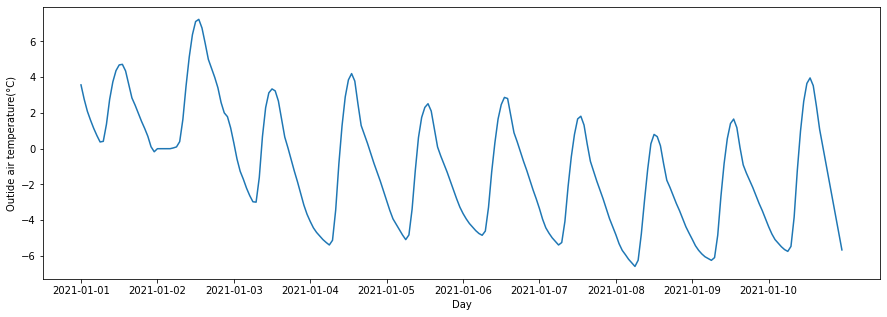

In [ ]:
# Plot prediction results
xaxis = np.arange(0,len(X_test_m),1)
plt.figure(figsize=(15,5))
plt.plot(xaxis, y_test_m, xaxis, prediction_unpruned)
plt.legend(('Ground Truth','Prediction'))
plt.title('Decision Tree Regressor \nUnpruned Testing Data')
plt.xlabel("Day")
plt.ylabel("Power demand (W)")
plt.xticks(ticks=[i for i in range(len(xaxis)) if i%24==0], labels = testxlabels)
plt.show()
plt.figure(figsize=(15,5))
plt.xlabel("Day")
plt.ylabel("Outide air temperature(°C)")
plt.xticks(ticks=[i for i in range(len(xaxis)) if i%24==0], labels = testxlabels)
plt.plot(xaxis, X_test_m['Text_0'])
plt.show()

This single unpruned tree gives poor performance, but it demostrates the usage of the `DecisionTreeRegressor` method. If the method is called without setting parameters such as the maximum depth (number of internal nodes or splits on the longest branch), this method produces fully-grown decision trees, which are most of the time overly complex and lead to model over-fitting. See below maximum depth and number of leaves in of the unpruned decision tree. This serves as an illustration of how complex the tree can grow.

In [ ]:
print("Maximum depth of the unpruned regression tree: ", clf_unpruned.get_depth())
print("Number of leaves of the unpruned regression tree: ", clf_unpruned.get_n_leaves())

Maximum depth of the unpruned regression tree:  18
Number of leaves of the unpruned regression tree:  720


**Tree Pruning**

The process described above may produce good predictions on the training set, but is likely to overfit the data, leading to poor test set performance. This is because the resulting tree might be too complex. A smaller tree with fewer splits (that is, fewer regions $R_1,\ldots,R_J$) might lead to lower variance and better interpretation at the cost of a little bias. One possible alternative to the process described above is to build the tree only so long as the decrease in the RSS due to each split exceeds some (high) threshold. This strategy will result in smaller trees, but is too short-sighted since a seemingly worthless split early on in the tree might be followed by a very good split—that is, a split that leads to a large reduction in RSS later on.

Therefore, a better strategy is to grow a very large tree $T_0$, and then prune it back in order to obtain a subtree. How do we determine the best way to prune the tree? Intuitively, our goal is to select a subtree that leads to the lowest test error rate. Given a subtree, we can estimate its test error using cross-validation or the validation set approach. However, estimating the cross-validation error for every possible subtree would be too cumbersome, since there is an extremely large number of possible subtrees. Instead, we need a way to select a small set of subtrees for consideration.

*Cost complexity pruning* gives us a way to do just this. Rather than considering every possible subtree, we consider a sequence of trees indexed by a nonnegative tuning parameter $\alpha$.

For each value of α there corresponds a subtree $T ⊂ T_0$ such that

\begin{equation}
\sum_{m=1}^{|T|} \sum_{x_i \in R_m} (y_i-\hat{y}_{R_j})^2 + \alpha |T|
\end{equation}

is as small as possible. Here $|T|$ indicates the number of terminal nodes of the tree $T$ , $R_m$ is the rectangle (i.e., the subset of predictor space) corresponding to the $m$-th terminal node, and $\hat{y}_{R_j}$ is the predicted response associated with $R_m$, i.e., the mean of the training observations in $R_m$. The tuning parameter $\alpha$ controls a trade-off between the subtree’s complexity and its fit to the training data. When $\alpha = 0$, then the subtree $T$ will simply equal $T_0$, because then the equation above just measures the training error. However, as $\alpha$ increases, there is a price to pay for having a tree with many terminal nodes, and so the quantity will tend to be minimized for a smaller subtree. This equation is reminiscent of the Lasso introduced below, in which a similar formulation was used in order to control the complexity of a linear regression model.

It turns out that as we increase $\alpha$ from zero in, branches get pruned from the tree in a nested and predictable fashion, so obtaining the whole sequence of subtrees as a function of $\alpha$ is easy. We can select a value of $\alpha$ using a validation set or using cross-validation. We then return to the full data set and obtain the subtree corresponding to $\alpha$


This notebook implements the cost-complexity pruning approach described [here](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html?highlight=tree%20pruning).

The amount of pruning is controlled by the parameter $\alpha$. The more $\alpha$ increases, the more the tree growth is restricted. The impurity (here, the sum of means squared error (MSE) computed on each leaf) of the tree increases as more of the tree is pruned, as shown in the figure below:

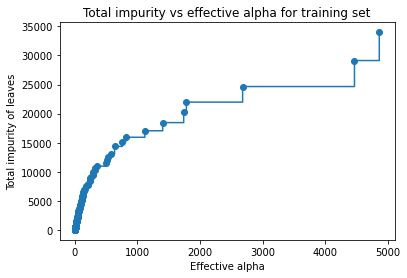

In [ ]:
# Create a new regression tree object
clf_pruning = DecisionTreeRegressor()
# Create a path for all values of alpha, from zero to largest, which leads to the smallest tree.
path = clf_pruning.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# Plot increase in tree impurity with alpha
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total impurity vs effective alpha for training set")
plt.show()

In order to find the optimal value for $\alpha$, which will decrease tree complexity to a point where the model does not over-fit the data while maintaining the highest accuracy, we compute the training and testing scores for all values of $\alpha$.

In [ ]:
# Create a regression tree for each element of the cost complexity path
clfs = []
count = 1
for ccp_alpha in ccp_alphas:
    clf_p = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf_p.fit(X_train, y_train)
    clfs.append(clf_p)
    count+=1
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
  clfs[-1].tree_.node_count, ccp_alphas[-1]))

# Drop the tree with maximum alpha, which is a trivial tree with only one leaf  
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

Number of nodes in the last tree is: 1 with ccp_alpha: 25791.475068403364


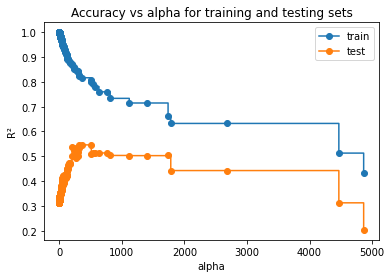

In [ ]:
# Compute accuracy (MSE or R2) for each value of alpha for both training and testing data
# Select "R²" or "MSE" in the following line

metric = "R²" # "R²" or "MSE"

if metric == "R²":
  train_scores = [clf.score(X_train, y_train) for clf in clfs]
  test_scores = [clf.score(X_test_m, y_test_m) for clf in clfs]
elif metric == "MSE":
  train_scores = [mean_squared_error(y_train, clf.predict(X_train)) for clf in clfs]
  test_scores = [mean_squared_error(y_test_m, clf.predict(X_test_m)) for clf in clfs]
else:
  print("Error: metric not recognized. Please select \"R²\" or \"MSE\".")

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel(metric)
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
    drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
    drawstyle="steps-post")
ax.legend()
plt.show()

We can magnify the plot to see the point where testing accuracy is highest.

Best R²: 54.75 %
Corresponding alpha: 314.85 at index 690 out of 706 indices.


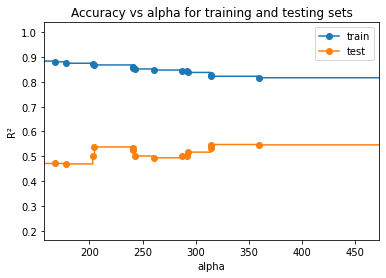

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel(metric)
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
    drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
    drawstyle="steps-post")

# Find best alpha that optimizes testing performance
best_alpha = -1
index = -1
if metric == "MSE":
  max_score = 100000
  for i in range(len(test_scores)):
    if test_scores[i] < max_score:
      max_score = test_scores[i]
      best_alpha = ccp_alphas[i]
      index = i
  print("Best MSE: %.2f Watts" % max_score)
  print("Corresponding alpha: %.2f at index %d out of %d indices." % (best_alpha, index, len(test_scores)))
else:
  max_score = -1
  for i in range(len(test_scores)):
    if test_scores[i] > max_score:
      max_score = test_scores[i]
      best_alpha = ccp_alphas[i]
      index = i  
  print("Best R²: %.2f %%" % (max_score*100))
  print("Corresponding alpha: %.2f at index %d out of %d indices." % (best_alpha, index, len(test_scores)))

ax.legend()
ax.set_xlim(max(0, best_alpha*0.5), min(ccp_alphas[-1], best_alpha*1.5))
#ax.set_ylim(0.5, 1.1)
plt.show()

Below, a comparison of the prediction of a fully-grown tree (alpha = 0), a tree with the optimal alpha (the value that yields the best testing accuracy), and the maximum value for alpha, which gives a tree with two splits.

In [ ]:
prediction_alphas = [clf.predict(X_test_m) for clf in [clfs[0], clfs[index], clfs[-1]]]

In [ ]:
print("Maximum depth of unpruned regression tree: ", clfs[0].tree_.max_depth)
print("Number of leaves of unpruned regression tree: ", clfs[0].get_n_leaves())
print("Maximum depth of pruned regression tree: ", clfs[index].tree_.max_depth)
print("Number of leaves of pruned regression tree: ", clfs[index].get_n_leaves())
print("Maximum depth of smallest regression tree: ", clfs[-1].tree_.max_depth)
print("Number of leaves of smallest regression tree: ", clfs[-1].get_n_leaves())

Maximum depth of unpruned regression tree:  18
Number of leaves of unpruned regression tree:  720
Maximum depth of pruned regression tree:  6
Number of leaves of pruned regression tree:  18
Maximum depth of smallest regression tree:  1
Number of leaves of smallest regression tree:  2


Here is a plot of the training predictions for the pruned tree:

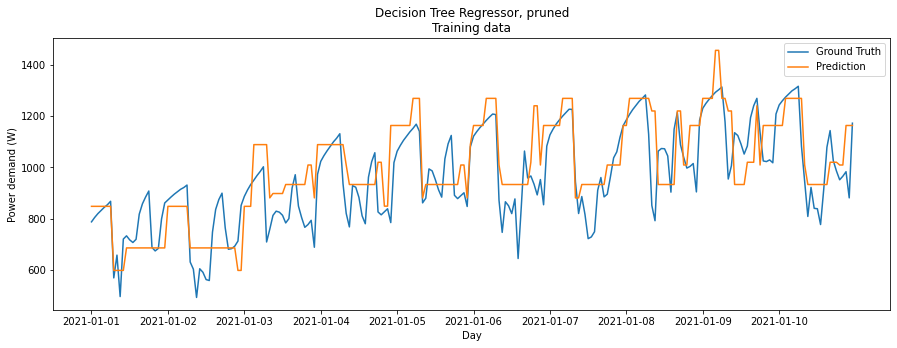

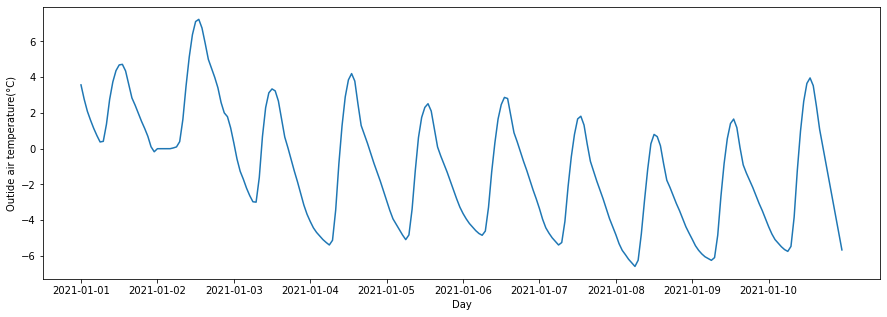

In [ ]:
# Plot prediction results
xaxis = np.arange(0,len(X_test_m),1)
plt.figure(figsize=(15,5))
plt.plot(xaxis, y_test_m, xaxis, prediction_alphas[1])
plt.legend(('Ground Truth','Prediction'))
plt.title('Decision Tree Regressor, pruned\nTraining data')
plt.xlabel("Day")
plt.ylabel("Power demand (W)")
plt.xticks(ticks=[i for i in range(len(xaxis)) if i%24==0], labels = testxlabels)
plt.show()
plt.figure(figsize=(15,5))
plt.xlabel("Day")
plt.ylabel("Outide air temperature(°C)")
plt.xticks(ticks=[i for i in range(len(xaxis)) if i%24==0], labels = testxlabels)
plt.plot(xaxis, X_test_m['Text_0'])
plt.show()

Below, a comparison of predictions using the fully-grown tree, optimally pruned tree, and the smallest tree with 3 splits, using the testing data.

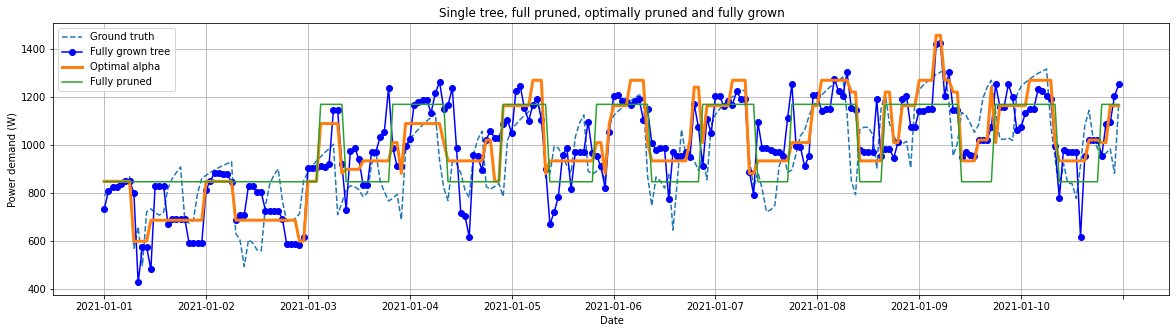

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(xaxis, y_test_m, label='Ground truth', linestyle='--')
plt.plot(xaxis, prediction_alphas[0], label='Fully grown tree', marker = 'o', color = 'b')
plt.plot(xaxis, prediction_alphas[1], label='Optimal alpha', linewidth=3)
plt.plot(xaxis, prediction_alphas[2], label='Fully pruned')
plt.title('Single tree, full pruned, optimally pruned and fully grown')
plt.legend()
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)
plt.xlabel("Date")
plt.ylabel("Power demand (W)")
plt.grid()
plt.show()

This is a visual representation of the pruned tree:

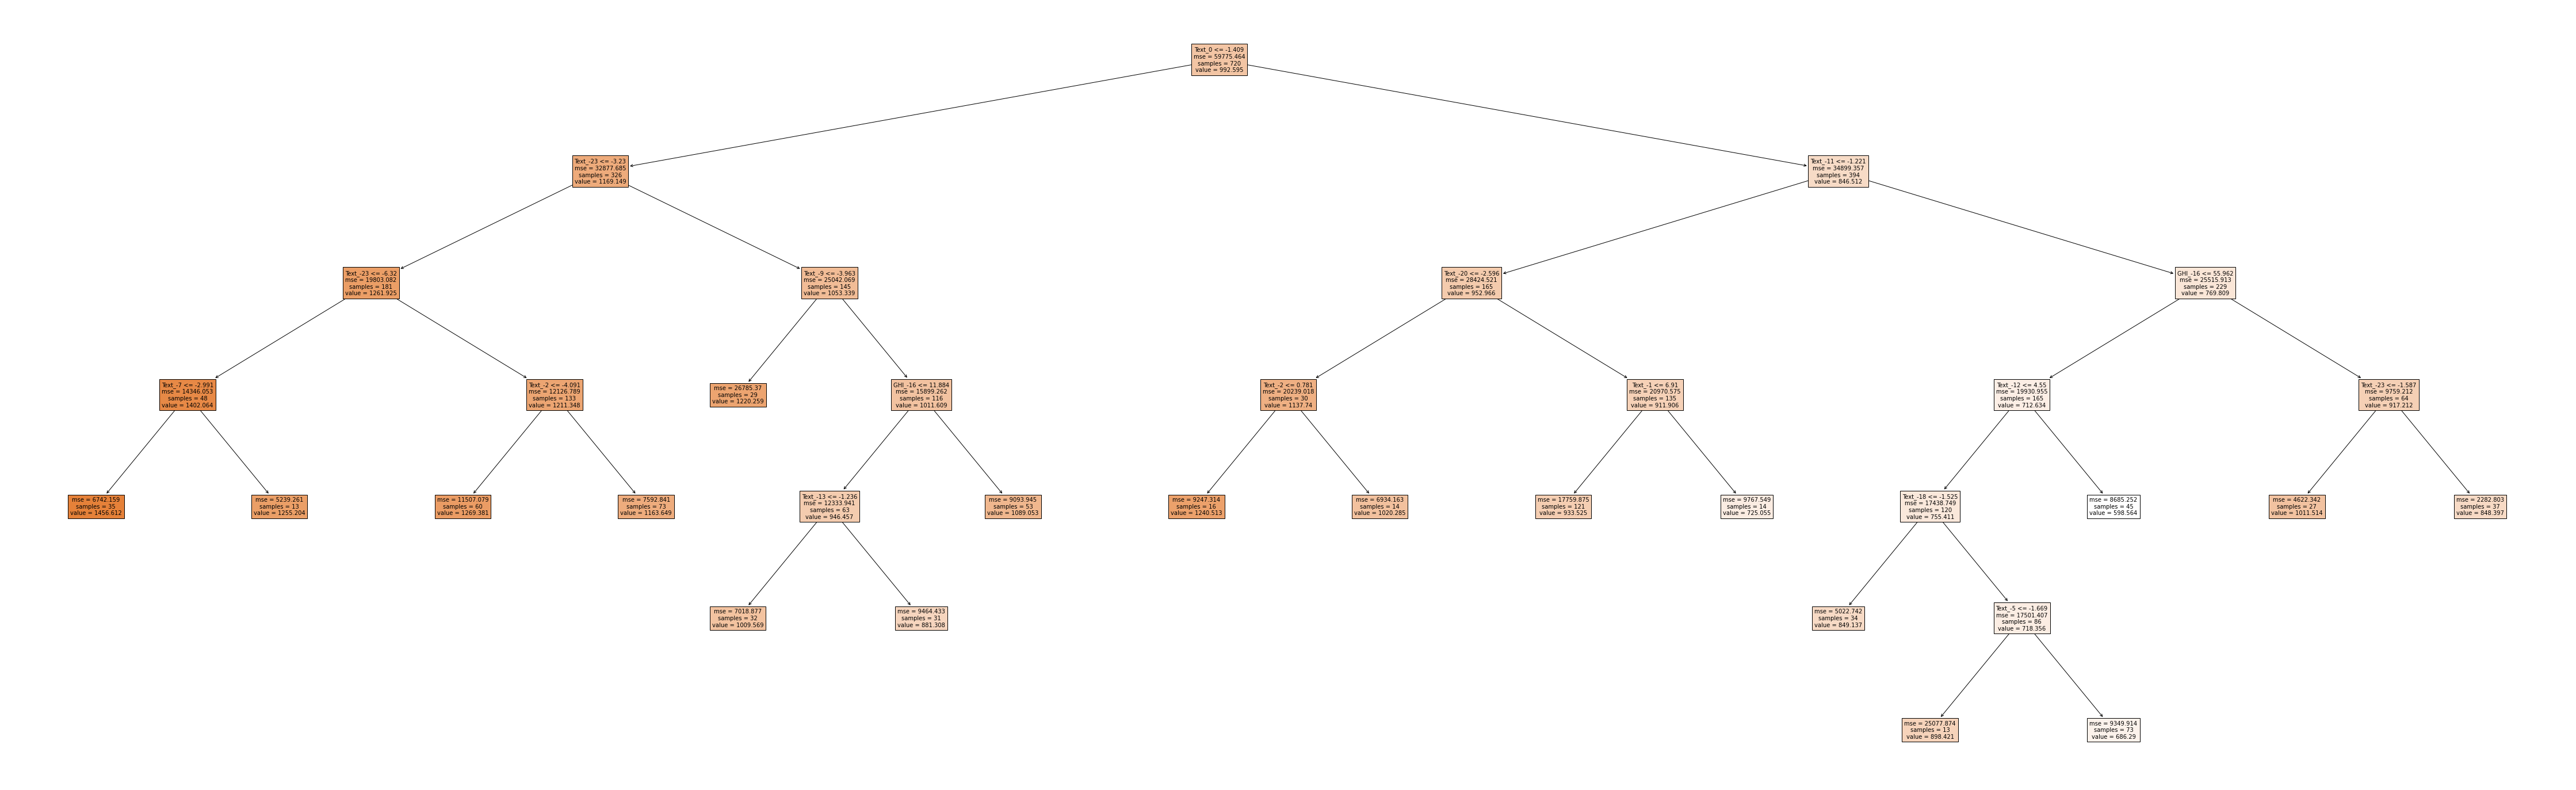

In [ ]:
plt.figure(figsize=(80, 25))
tree.plot_tree(clfs[index], filled=True, fontsize=10, feature_names=X_train.columns)
plt.show()

**Predictor Importance**

Not all predictors provide meaningful information when extracting the regression tree. Here, we assess the importance of each predictor on the model quality, using permutation importance. Read more about it [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html?highlight=permutation%20importance). The plot represents the mean accuracy decrease when removing each predictor from a forest of fully-grown trees. This plot informs us about the relative importance of each predictor. For example, we can say that the current external air temperature is the most important predictor when evaluating the system's heating and cooling load.

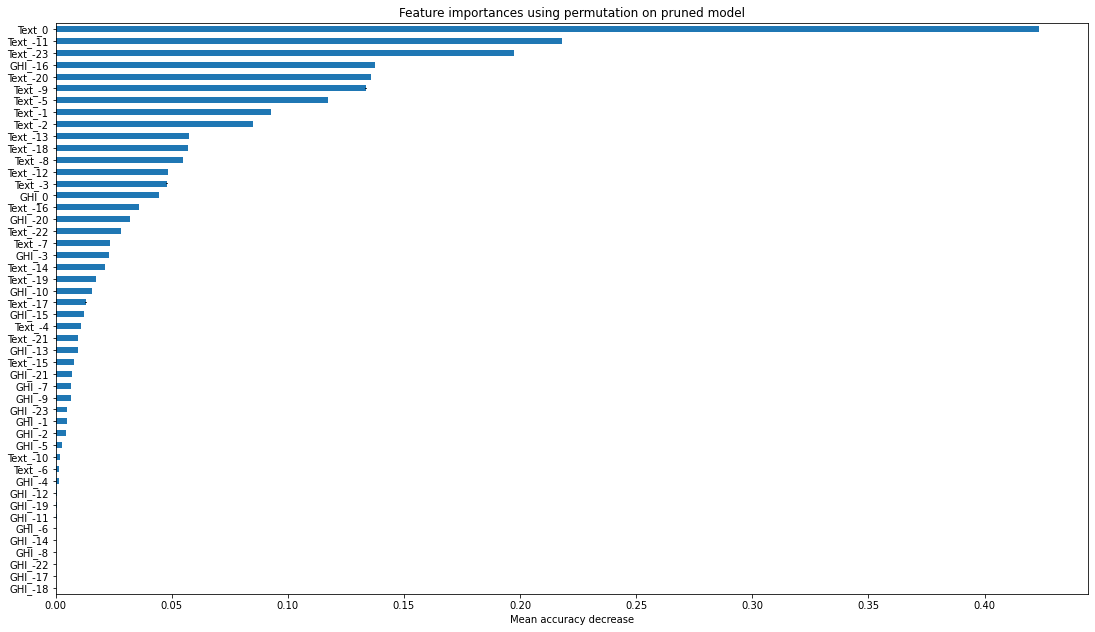

In [ ]:
# Extract all feature names
feature_names = [str(name) for name in inp.columns]
result = permutation_importance(clfs[0], X_train, y_train, n_repeats=100, random_state=0)
feature_names_pos = []
# Extract mean feature importance, limited to nonzero positive values.
for i in range(len(feature_names)):
  if result.importances_mean[i] > 0:
    feature_names_pos.append(feature_names[i])
forest_importances = pd.Series([importance for importance in result.importances_mean if importance > 0], index=feature_names_pos)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
forest_importances.sort_values().plot.barh(yerr=[result.importances_std[i] for i in range(len(result.importances_std)) if result.importances_mean[i] >0], ax=ax)
ax.set_title("Feature importances using permutation on pruned model")
ax.set_xlabel("Mean accuracy decrease")
plt.show()

If we limit the cost complexity parameter $\alpha$ to the value that we found after pruning, here is the predictor importance plot:

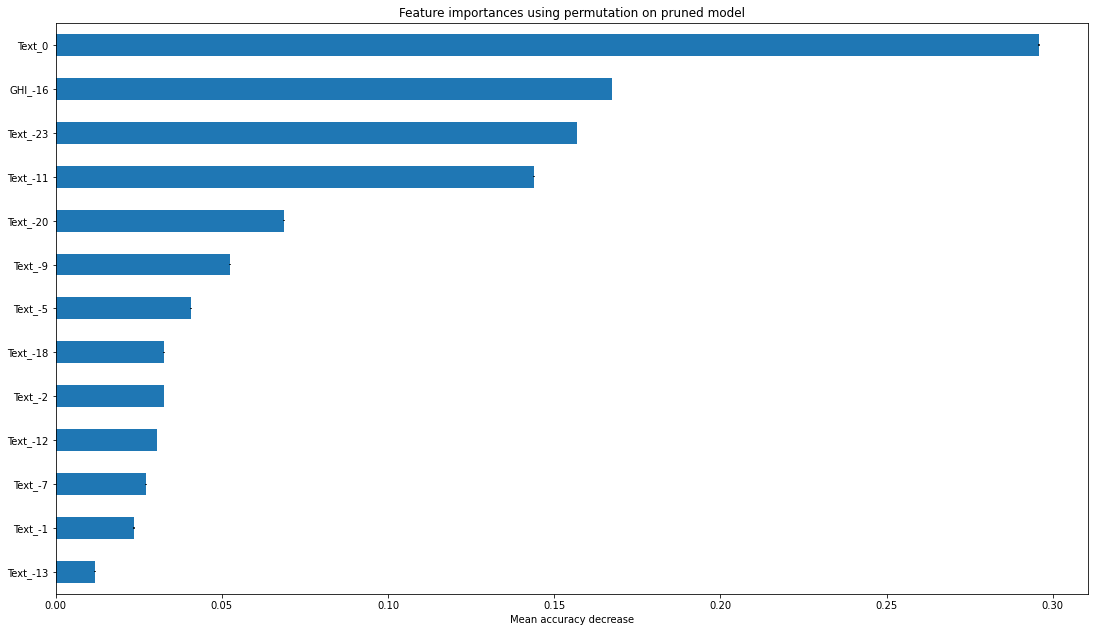

In [ ]:
# Extract all feature names
feature_names = [str(name) for name in inp.columns]
result = permutation_importance(clfs[index], X_train, y_train, n_repeats=100, random_state=0)
feature_names_pos = []
# Extract mean feature importance, limited to nonzero positive values.
for i in range(len(feature_names)):
  if result.importances_mean[i] > 0:
    feature_names_pos.append(feature_names[i])
forest_importances = pd.Series([importance for importance in result.importances_mean if importance > 0], index=feature_names_pos)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
forest_importances.sort_values().plot.barh(yerr=[result.importances_std[i] for i in range(len(result.importances_std)) if result.importances_mean[i] >0], ax=ax)
ax.set_title("Feature importances using permutation on pruned model")
ax.set_xlabel("Mean accuracy decrease")
plt.show()

We compute the 1-day predictions, 10 times, at midnight each day for 10 days. We compute the CV(RMSE) on this 10-day prediction.

In [ ]:
final_results = []
clf_best = clfs[index]
for k in range(numdays):
  # One-step ahead forecast, repeated for the length of the test vector
  x_train_moving = inp.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  y_train_moving = out.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  clf_best.fit(x_train_moving, y_train_moving)
  x_test = X_test_m.iloc[k * testlen : k * testlen + testlen].copy()
  final_results.append(clf_best.predict(x_test.to_numpy()))

xresults = [[i+j*24 for i in range(len(final_results[0]))] for j in range(len(final_results))]
xtesting = [i for i in range(len(y_test_m))]
global_pruned_results = [item for sublist in final_results for item in sublist]
final_cvrmse = truncate(cvrmse(global_pruned_results, y_test_m), 3)

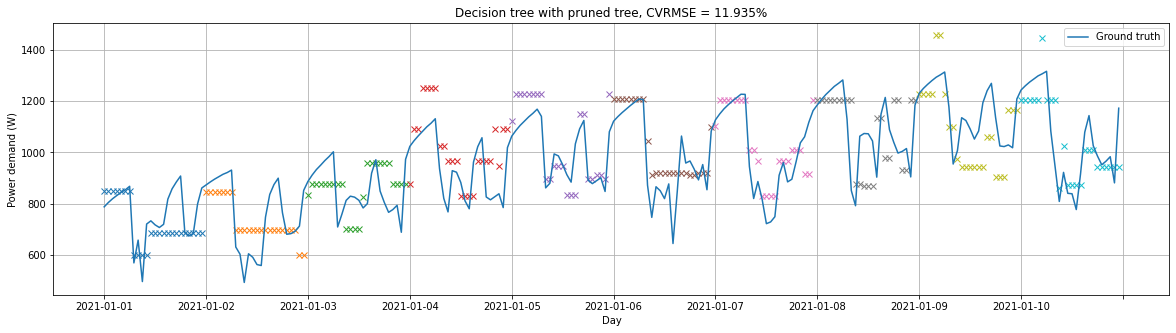

In [ ]:
plt.figure(figsize=(20, 5))
plt.xlabel("Day")
plt.ylabel("Power demand (W)")
for i in range(len(final_results)):
    plt.plot(xresults[i], final_results[i], 'x')
plt.plot(xtesting, y_test_m, label='Ground truth')
plt.title('Decision tree with pruned tree, CVRMSE = '+str(final_cvrmse)+"%")
plt.legend()
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

## **Approach 2: Tree Bagging**

The decision trees discussed thus far suffer from high variance. This means that if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be quite different. In contrast, a procedure with low variance will yield similar results if applied repeatedly to distinct data sets; linear regression tends to have low variance, if the ratio of $n$ samples to $p$ predictors is moderately large. Bootstrap aggregation, or bagging, is a general-purpose procedure for reducing the variance of a statistical learning method; we introduce it here because it is particularly useful and frequently used in the context of decision trees.

Recall that given a set of $n$ independent observations $Z_1,\ldots,Z_n$, each with variance $\sigma^2$, the variance of the mean $\bar{Z}$ of the observations is given by $\sigma^2/n$. In other words, averaging a set of observations reduces variance. Hence a natural way to reduce the variance and hence increase the prediction accuracy of a statistical learning method is to take many training sets from the population, build a separate prediction model using each training set, and average the resulting predictions. In other words, we could calculate $\hat{f}^1(x), \hat{f}^2(x),\ldots,\hat{f}^B(x)$ using $B$ separate training sets, and average them in order to obtain a single low-variance statistical learning model, given by

\begin{equation}
\hat{f}_{avg}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}^b(x)
\end{equation}

Of course, this is not practical because we generally do not have access to multiple training sets. Instead, we can bootstrap, by taking repeated samples from the (single) training data set. In this approach we generate $B$ different bootstrapped training data sets. We then train our method on the $b$-th bootstrapped training set in order to get $\hat{f}^{*b}(x)$, and finally average all the predictions, to obtain

\begin{equation}
\hat{f}_{bag}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}^{*b}(x)
\end{equation}

This is called bagging.

While bagging can improve predictions for many regression methods,
it is particularly useful for decision trees. To apply bagging to regression trees, we simply construct $B$ regression trees using $B$ bootstrapped training sets, and average the resulting predictions. *These trees are grown deep, and are not pruned.* Hence each individual tree has high variance, but low bias. Averaging these $B$ trees reduces the variance. Bagging has been demonstrated to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.

The number of trees $B$ is not a critical parameter with bagging; using a very large value of B will not lead to overfitting. In practice we use a value of B sufficiently large that the error has settled down.

The presented approach uses the Scikit's `BaggingRegressor` method.

**Basic bagging:**

In [ ]:
# Create B = 100 bagged trees
bagged = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100).fit(X_train, y_train)
prediction_bagging = bagged.predict(X_test_m)

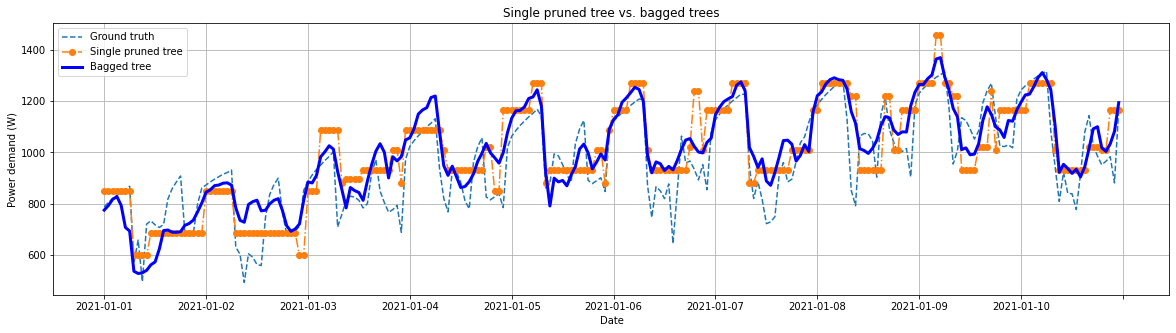

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(xaxis, y_test_m, label='Ground truth', linestyle='--')
plt.plot(xaxis, prediction_alphas[1], label='Single pruned tree', linestyle = '-.', marker = 'o')
plt.plot(xaxis, prediction_bagging, label='Bagged tree', linewidth=3, color='b')
plt.title('Single pruned tree vs. bagged trees')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Power demand (W)")
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

In [ ]:
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))

Pruned single tree: 	 R² = 54.75 % and MSE = 23140.49 Watts
Bagging: 	 	 R² = 67.92 % and MSE = 10853.97 Watts


On the current dataset, tree bagging provides a better estimator.

In [ ]:
bagging_results = []
for k in range(numdays):
  x_train_moving = inp.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  y_train_moving = out.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  bagged.fit(x_train_moving, y_train_moving)
  x_test = X_test_m.iloc[k * testlen : k * testlen + testlen].copy()
  bagging_results.append(bagged.predict(x_test.to_numpy()))   
   
xresults = [[i+j*24 for i in range(len(bagging_results[0]))] for j in range(len(bagging_results))]
xtesting = [i for i in range(len(y_test_m))]
global_results = [item for sublist in bagging_results for item in sublist]
bagging_cvrmse = truncate(cvrmse(global_results, y_test_m), 3)

And now predicting 10 days consecutively one after the other. 

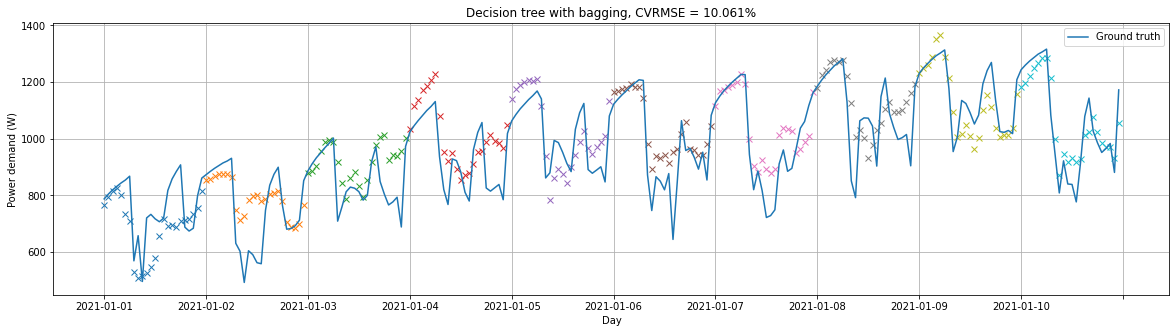

In [ ]:
plt.figure(figsize=(20, 5))
plt.xlabel("Day")
plt.ylabel("Power demand (W)")

for i in range(len(bagging_results)):   
    plt.plot(xresults[i], bagging_results[i], 'x')
plt.plot(xtesting, y_test_m, label='Ground truth')
plt.title('Decision tree with bagging, CVRMSE = '+str(bagging_cvrmse)+"%")
plt.legend()
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

**Random Patches**

Random patches are similar to bagging, except that both the training samples **and** subsets of the predictors are randomly picked for each subtree before combining the subtrees. 

Reference: G. Louppe and P. Geurts, “Ensembles on Random Patches”, Machine Learning and Knowledge Discovery in Databases, 346-361, 2012.

In [ ]:
random_patches = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, bootstrap_features=True).fit(X_train, y_train)
prediction_random_patches = random_patches.predict(X_test_m)

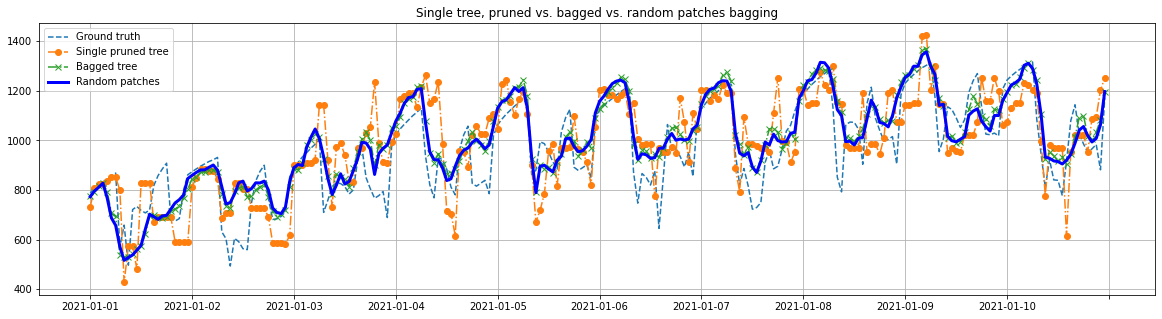

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(xaxis, y_test_m, label='Ground truth', linestyle='--')
plt.plot(xaxis, prediction_unpruned, label='Single pruned tree', linestyle = '-.', marker = 'o')
plt.plot(xaxis, prediction_bagging, label='Bagged tree', linestyle = '-.', marker = 'x')
plt.plot(xaxis, prediction_random_patches, label='Random patches', linewidth=3, color = 'b')
plt.title('Single tree, pruned vs. bagged vs. random patches bagging')
plt.legend()
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

In [ ]:
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))

Pruned single tree: 	 R² = 54.75 % and MSE = 23140.49 Watts
Bagging: 	 	 R² = 67.92 % and MSE = 10853.97 Watts
Random patches: 	 R² = 68.97 % and MSE = 10497.66 Watts


The metrics show that random patches, in our case, is similar to bagging.

In [ ]:
patches_results = []
for k in range(numdays):
  # One-step ahead forecast, repeated for the length of the test vector
  x_train_moving = inp.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  y_train_moving = out.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  random_patches.fit(x_train_moving, y_train_moving)
  x_test = X_test_m.iloc[k * testlen : k * testlen + testlen].copy()
  patches_results.append(random_patches.predict(x_test.to_numpy()))   
   
xresults = [[i+j*24 for i in range(len(patches_results[0]))] for j in range(len(patches_results))]
xtesting = [i for i in range(len(y_test_m))]
global_results = [item for sublist in patches_results for item in sublist]
patches_cvrmse = truncate(cvrmse(global_results, y_test_m), 3)

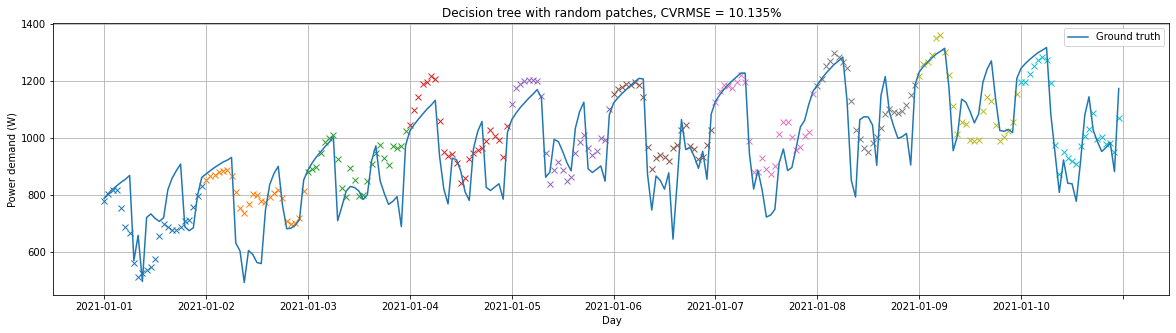

In [ ]:
plt.figure(figsize=(20, 5))
plt.xlabel("Day")
plt.ylabel("Power demand (W)")

for i in range(len(patches_results)):   
    plt.plot(xresults[i], patches_results[i], 'x')
plt.plot(xtesting, y_test_m, label='Ground truth')
plt.title('Decision tree with random patches, CVRMSE = '+str(patches_cvrmse)+"%")
plt.legend()
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)
plt.grid()
plt.show()

## **Approach 3: Random Forests**

Random forests provide an improvement over bagged trees by way of a small tweak that decorrelates the trees. As in bagging, we build a number of decision trees on bootstrapped training samples. But when building these decision trees, each time a split in a tree is considered, a random sample of $m$ predictors is chosen as split candidates from the full set of $p$ predictors. The split is allowed to use only one of those $m$ predictors. A fresh sample of $m$ predictors is taken at each split, and typically we choose $m \approx \sqrt{p}$ i.e., the number of predictors considered at each split is approximately equal to the square root of the total number of predictors.

In [ ]:
maxFeatures = round(math.sqrt(len(X_train.columns)))
print(maxFeatures)
rndForest = RandomForestRegressor(n_estimators=100, max_features = maxFeatures) 
rndForest.fit(X_train, y_train)
prediction_random_forest = rndForest.predict(X_test_m)

7


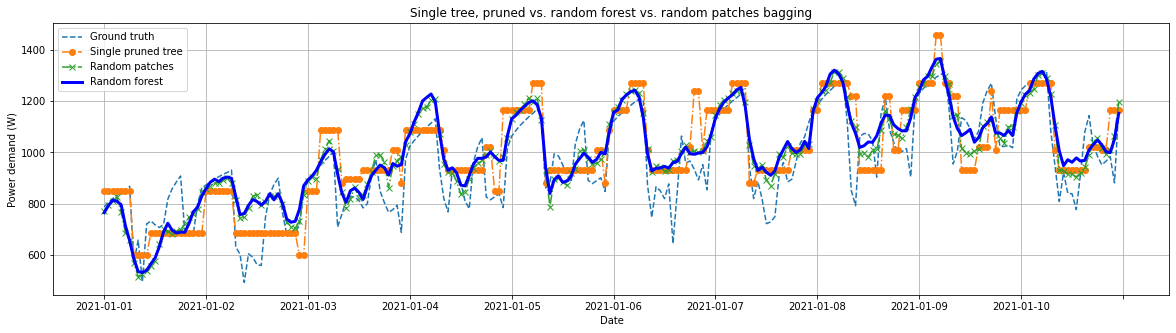

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(xaxis, y_test_m, label='Ground truth', linestyle='--')
plt.plot(xaxis, prediction_alphas[1], label='Single pruned tree', linestyle = '-.', marker = 'o')
plt.plot(xaxis, prediction_random_patches, label='Random patches', linestyle = '-.', marker = 'x')
plt.plot(xaxis, prediction_random_forest, label='Random forest', linewidth=3, color='b')
plt.title('Single tree, pruned vs. random forest vs. random patches bagging')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Power demand (W)")
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

In [ ]:
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))
print("Random forest: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_forest)*100), mean_squared_error(y_test_m, prediction_random_forest)))

Pruned single tree: 	 R² = 54.75 % and MSE = 23140.49 Watts
Bagging: 	 	 R² = 67.92 % and MSE = 10853.97 Watts
Random patches: 	 R² = 68.97 % and MSE = 10497.66 Watts
Random forest: 	 	 R² = 69.54 % and MSE = 10305.77 Watts


In our case, the random forest is significantly better than random patches.

In [ ]:
rnd_forest_results = []
for k in range(numdays):
    
  # One-step ahead forecast, repeated for the length of the test vector
  x_train_moving = inp.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  y_train_moving = out.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  rndForest.fit(x_train_moving, y_train_moving)
  x_test = X_test_m.iloc[k * testlen : k * testlen + testlen].copy()
  rnd_forest_results.append(rndForest.predict(x_test.to_numpy()) )  
   
xresults = [[i+j*24 for i in range(len(rnd_forest_results[0]))] for j in range(len(rnd_forest_results))]
xtesting = [i for i in range(len(y_test_m))]
global_results = [item for sublist in rnd_forest_results for item in sublist]
rnd_forest_cvrmse = truncate(cvrmse(global_results, y_test_m), 3)

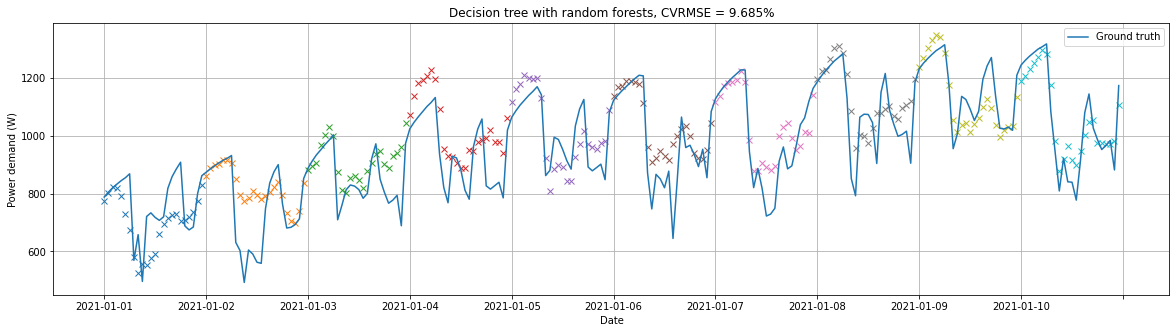

In [ ]:
plt.figure(figsize=(20, 5))
plt.xlabel("Date")
plt.ylabel("Power demand (W)")

for i in range(len(rnd_forest_results)):
    
    plt.plot(xresults[i], rnd_forest_results[i], 'x')
plt.plot(xtesting, y_test_m, label='Ground truth')
plt.title('Decision tree with random forests, CVRMSE = '+str(rnd_forest_cvrmse)+"%")
plt.legend()
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

## **Approach 4: Boosting**

We now discuss boosting, yet another approach for improving the predictions resulting from a decision tree. Like bagging, boosting is a general approach that can be applied to many statistical learning methods for regression or classification. Here we restrict our discussion of boosting to the context of decision trees.

Recall that bagging involves creating multiple copies of the original training data set using the bootstrap, fitting a separate decision tree to each copy, and then combining all of the trees in order to create a single predictive model. Notably, each tree is built on a bootstrap data set, independent of the other trees. Boosting works in a similar way, except that the trees are grown sequentially: each tree is grown using information from previously grown trees. Boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.

Consider first the regression setting. Like bagging, boosting involves com- bining a large number of decision trees, $\hat{f}^1, \ldots ,\hat{f}^B$. What is the idea behind this procedure? Unlike fitting a single large decision tree to the data, which amounts to fitting the data hard and potentially overfitting, the boosting approach instead learns slowly. Given the current model, we fit a decision tree to the residuals from the model. That is, we fit a tree using the current residuals, rather than the outcome $Y$, as the response. We then add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes, determined by the parameter $d$ in the algorithm. By fitting small trees to the residuals, we slowly improve $\hat{f}$ in areas where it does not perform well. The shrinkage parameter $\lambda$ slows the process down even further, allowing more and different shaped trees to attack the residuals. In general, statistical learning approaches that learn slowly tend to perform well. Note that in boosting, unlike in bagging, the construction of each tree depends strongly on the trees that have already been grown.

Boosting has three tuning parameters:
1. The number of trees $B$. Unlike bagging and random forests, boosting can overfit if $B$ is too large, although this overfitting tends to occur slowly if at all. 
2. The shrinkage parameter $\lambda$,a small positive number. This controls the rate at which boosting learns. Typical values are 0.01 or 0.001, and the right choice can depend on the problem. Very small $\lambda$ can require using a very large value of $B$ in order to achieve good performance.
3. The number $d$ of splits in each tree, which controls the complexity of the boosted ensemble. Often $d = 1$ works well, in which case each tree is a stump, consisting of a single split. In this case, the boosted ensemble is fitting an additive model, since each term involves only a single variable. More generally d is the interaction depth, and controls



In [ ]:
boost = AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth = 2), learning_rate = 0.1, n_estimators=5000)  
boost.fit(X_train, y_train)
prediction_boost = boost.predict(X_test_m)

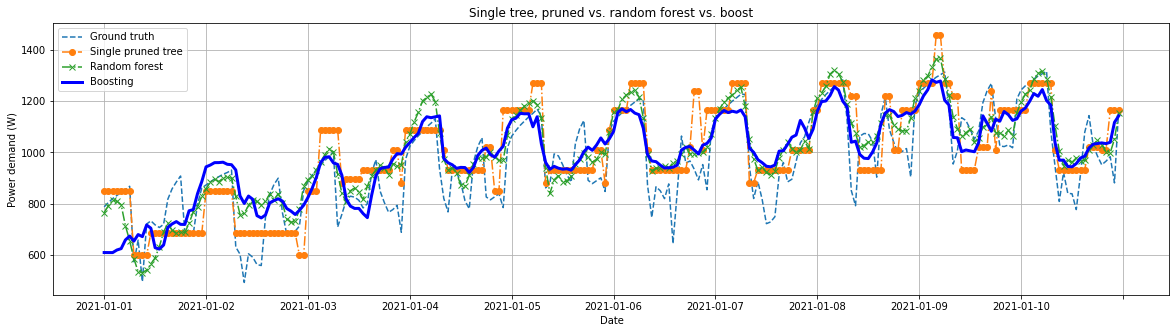

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(xaxis, y_test_m, label='Ground truth', linestyle='--')
plt.plot(xaxis, prediction_alphas[1], label='Single pruned tree', linestyle = '-.', marker = 'o')
plt.plot(xaxis, prediction_random_forest, label='Random forest', linestyle = '-.', marker = 'x')
plt.plot(xaxis, prediction_boost, label='Boosting', linewidth=3, color='b')
plt.title('Single tree, pruned vs. random forest vs. boost')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Power demand (W)")
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

In [ ]:
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))
print("Random forest: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_forest)*100), mean_squared_error(y_test_m, prediction_random_forest)))
print("Boosting: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_boost)*100), mean_squared_error(y_test_m, prediction_boost)))

Pruned single tree: 	 R² = 54.75 % and MSE = 23140.49 Watts
Bagging: 	 	 R² = 67.92 % and MSE = 10853.97 Watts
Random patches: 	 R² = 68.97 % and MSE = 10497.66 Watts
Random forest: 	 	 R² = 69.54 % and MSE = 10305.77 Watts
Boosting: 	 	 R² = 61.49 % and MSE = 13027.29 Watts


Boosting does not perform as well as bagging, random patches, and random forests for this case. 

In [ ]:
boost_results = []
for k in range(numdays):
    
  # One-step ahead forecast, repeated for the length of the test vector
  x_train_moving = inp.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  y_train_moving = out.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  boost.fit(x_train_moving, y_train_moving)
  x_test = X_test_m.iloc[k * testlen : k * testlen + testlen].copy()
  boost_results.append(boost.predict(x_test.to_numpy()))   
   
xresults = [[i+j*24 for i in range(len(boost_results[0]))] for j in range(len(boost_results))]
xtesting = [i for i in range(len(y_test_m))]
global_results = [item for sublist in boost_results for item in sublist]
boost_cvrmse = truncate(cvrmse(global_results, y_test_m), 3)

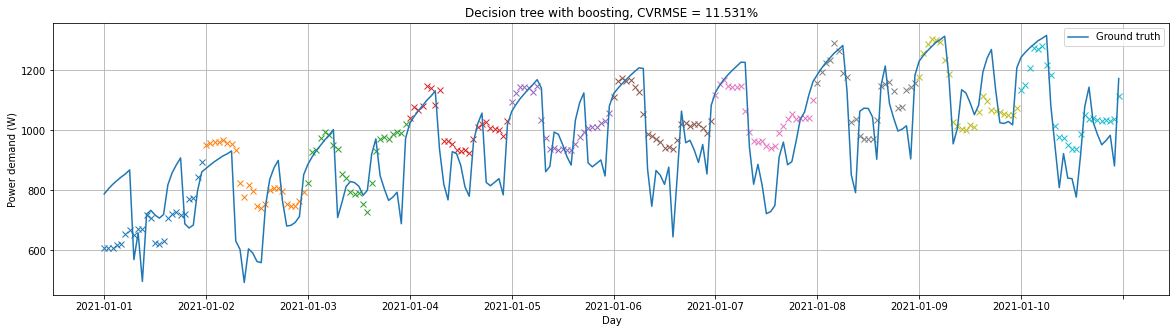

In [ ]:
plt.figure(figsize=(20, 5))
plt.xlabel("Day")
plt.ylabel("Power demand (W)")

for i in range(len(boost_results)):
    
    plt.plot(xresults[i], boost_results[i], 'x')
plt.plot(xtesting, y_test_m, label='Ground truth')
plt.title('Decision tree with boosting, CVRMSE = '+str(boost_cvrmse)+"%")
plt.legend()
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

#**Linear and Lasso Regression**

In this section, we are considering simple multilinear and regularized Lasso regression with its regularization parameter found from $k$-fold cross-validation.





In [ ]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression().fit(X_train, y_train)
lreg.score(X_train, y_train)
prediction_lreg = lreg.predict(X_test_m)

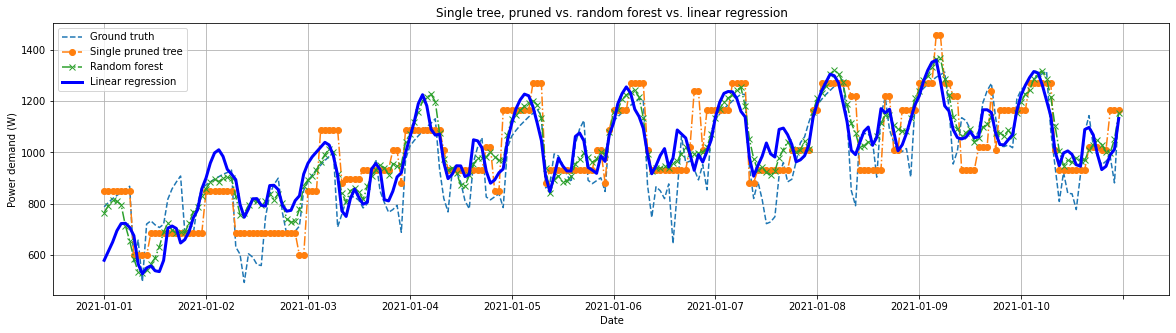

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(xaxis, y_test_m, label='Ground truth', linestyle='--')
plt.plot(xaxis, prediction_alphas[1], label='Single pruned tree', linestyle = '-.', marker = 'o')
plt.plot(xaxis, prediction_random_forest, label='Random forest', linestyle = '-.', marker = 'x')
plt.plot(xaxis, prediction_lreg, label='Linear regression', linewidth=3, color='b')
plt.title('Single tree, pruned vs. random forest vs. linear regression')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Power demand (W)")
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

In [ ]:
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))
print("Random forest: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_forest)*100), mean_squared_error(y_test_m, prediction_random_forest)))
print("Boosting: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_boost)*100), mean_squared_error(y_test_m, prediction_boost)))
print("Linear regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))

Pruned single tree: 	 R² = 54.75 % and MSE = 23140.49 Watts
Bagging: 	 	 R² = 67.92 % and MSE = 10853.97 Watts
Random patches: 	 R² = 68.97 % and MSE = 10497.66 Watts
Random forest: 	 	 R² = 69.54 % and MSE = 10305.77 Watts
Boosting: 	 	 R² = 61.49 % and MSE = 13027.29 Watts
Linear regression: 	 R² = 68.15 % and MSE = 10776.49 Watts


In [ ]:
lreg_results = []
for k in range(numdays):
    
  # One-step ahead forecast, repeated for the length of the test vector
  x_train_moving = inp.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  y_train_moving = out.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  lreg.fit(x_train_moving, y_train_moving)
  x_test = X_test_m.iloc[k * testlen : k * testlen + testlen].copy()
  lreg_results.append(lreg.predict(x_test.to_numpy()) )  
   
xresults = [[i+j*24 for i in range(len(lreg_results[0]))] for j in range(len(lreg_results))]
xtesting = [i for i in range(len(y_test_m))]
global_results = [item for sublist in lreg_results for item in sublist]
lreg_cvrmse = truncate(cvrmse(global_results, y_test_m), 3)

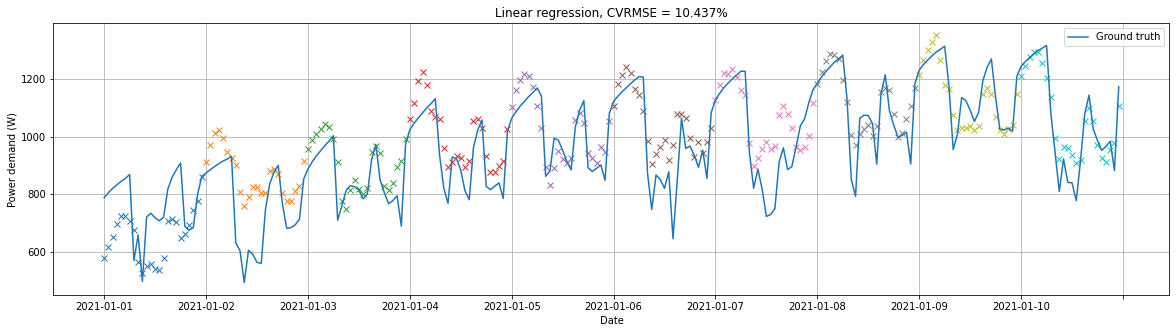

In [ ]:
plt.figure(figsize=(20, 5))
plt.xlabel("Date")
plt.ylabel("Power demand (W)")

for i in range(len(lreg_results)):
    
    plt.plot(xresults[i], lreg_results[i], 'x')
plt.plot(xtesting, y_test_m, label='Ground truth')
plt.title('Linear regression, CVRMSE = '+str(lreg_cvrmse)+"%")
plt.legend()
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

Now, we are moving to a Lasso regression. We can fit a model containing all $p$ predictors using a technique that constrains or regularizes the coefficient estimates, or equivalently, that shrinks the coefficient estimates towards zero. It may not be immediately obvious why such a constraint should improve the fit, but it turns out that shrinking the coefficient estimates can significantly reduce their variance. The two best-known techniques for shrinking the regression coefficients towards zero are ridge regression and the lasso.

Recall that the ordinary least squares fitting procedure estimates $\beta_0, \beta_1, \ldots, \beta_p$ using the values that minimize

\begin{equation}
  RSS = \sum_{i \in R_j} ( y_i-\beta_0-\sum_{j=1}^p \beta_j x_{ij})^2
\end{equation}

Lasso regression is very similar to least squares, except that the coefficients are estimated by minimizing a slightly different quantity. In particular, the lasso regression coefficient estimates $\hat{\beta}^L$ are the values that minimize

\begin{equation}
  RSS + \lambda \sum_{j=1}^p |\beta_j |
\end{equation}

In statistical parlance, the lasso uses an $l_1$ (pronounced “ell 1”) penalty instead of an $l_2$ penalty. The $l_1$ norm of a coefficient vector $\beta$ is given by $||\beta||=\sum |\beta_j|$.  As with ridge regression, the lasso shrinks the coefficient estimates towards zero. However, in the case of the lasso, the $l_1$ penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter $\lambda$ is sufficiently large. *Hence, much like best subset selection, the lasso performs variable selection.* As a result, models generated from the lasso are generally much easier to interpret than those produced by ridge regression. We say that the lasso yields sparse models—that is, models that involve only a subset of the variables. As in ridge regression, selecting a good value of $\lambda$ for the lasso is critical. There are very efficient algorithms for fitting both ridge and lasso models; in both cases the entire coefficient paths can be computed with about the same amount of work as a single least squares fit. 



In [ ]:
from sklearn.linear_model import LassoCV
lassoreg = LassoCV(cv=5, max_iter = 5000, random_state=0).fit(X_train, y_train)
lassoreg.score(X_train, y_train)
prediction_lassoreg = lassoreg.predict(X_test_m)

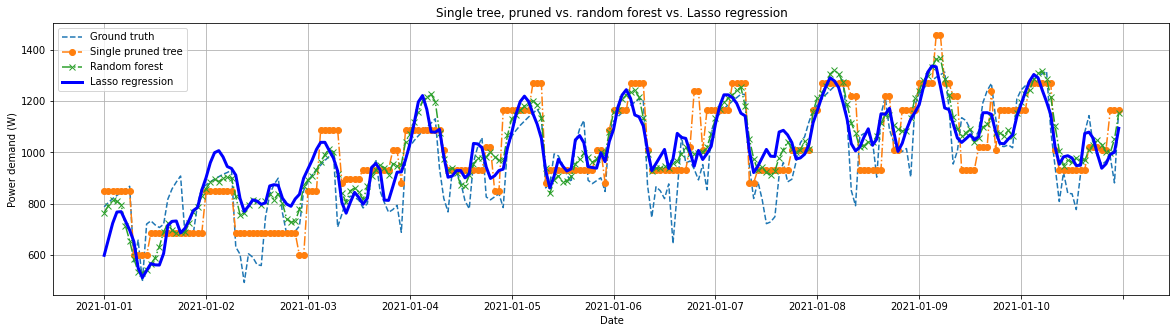

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(xaxis, y_test_m, label='Ground truth', linestyle='--')
plt.plot(xaxis, prediction_alphas[1], label='Single pruned tree', linestyle = '-.', marker = 'o')
plt.plot(xaxis, prediction_random_forest, label='Random forest', linestyle = '-.', marker = 'x')
plt.plot(xaxis, prediction_lassoreg, label='Lasso regression', linewidth=3, color='b')
plt.title('Single tree, pruned vs. random forest vs. Lasso regression')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Power demand (W)")
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

In [ ]:
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))
print("Random forest: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_forest)*100), mean_squared_error(y_test_m, prediction_random_forest)))
print("Boosting: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_boost)*100), mean_squared_error(y_test_m, prediction_boost)))
print("Linear regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))
print("Lasso regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lassoreg)*100), mean_squared_error(y_test_m, prediction_lassoreg)))

Pruned single tree: 	 R² = 54.75 % and MSE = 23140.49 Watts
Bagging: 	 	 R² = 67.92 % and MSE = 10853.97 Watts
Random patches: 	 R² = 68.97 % and MSE = 10497.66 Watts
Random forest: 	 	 R² = 69.54 % and MSE = 10305.77 Watts
Boosting: 	 	 R² = 61.49 % and MSE = 13027.29 Watts
Linear regression: 	 R² = 68.15 % and MSE = 10776.49 Watts
Lasso regression: 	 R² = 68.72 % and MSE = 10581.54 Watts


In [ ]:
lassoreg_results = []
for k in range(numdays):
    
  # One-step ahead forecast, repeated for the length of the test vector
  x_train_moving = inp.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  y_train_moving = out.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  lassoreg.fit(x_train_moving, y_train_moving)
  x_test = X_test_m.iloc[k * testlen : k * testlen + testlen].copy()
  lassoreg_results.append(lassoreg.predict(x_test.to_numpy()) )  
   
xresults = [[i+j*24 for i in range(len(lassoreg_results[0]))] for j in range(len(lassoreg_results))]
xtesting = [i for i in range(len(y_test_m))]
global_results = [item for sublist in lassoreg_results for item in sublist]
lassoreg_cvrmse = truncate(cvrmse(global_results, y_test_m), 3)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5786.83203125, tolerance: 3264.085205078125
  tol, rng, random, positive)


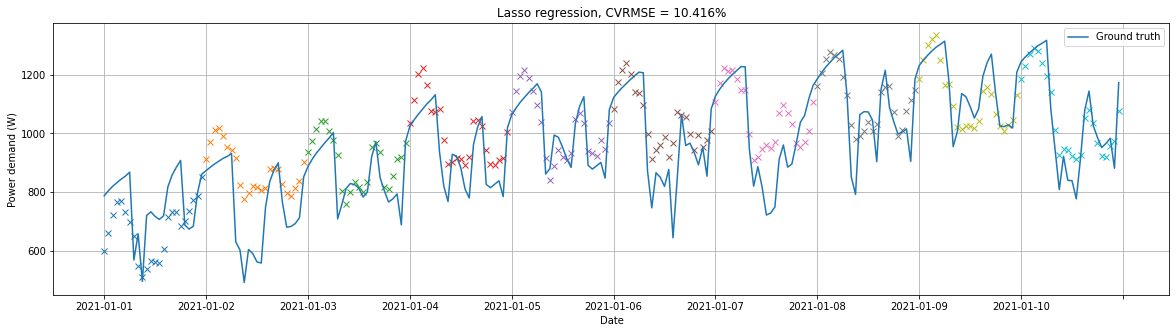

In [ ]:
plt.figure(figsize=(20, 5))
plt.xlabel("Date")
plt.ylabel("Power demand (W)")

for i in range(len(lassoreg_results)):
    
    plt.plot(xresults[i], lassoreg_results[i], 'x')
plt.plot(xtesting, y_test_m, label='Ground truth')
plt.title('Lasso regression, CVRMSE = '+str(lassoreg_cvrmse)+"%")
plt.legend()
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

#**Support Vector Regression**

The support vector algorithm is a class of nonlinear generalization algorithms developed in the early 1960s. Support vectors are created by minimizing the error between the proposed hyperplane and the training data. Once minimized, the datapoints that are used to define the "tube" are the support vectors. If a support vector is removed, then the shape and performance of the model can change significantly.

Support vector algorithms use kernel functions to select the observed data that are included in the minimization equation. The most common kernels are linear, polynomial, sigmoid, and radial basis functions. The radial basis function (RBF) (equation below) was used in this analysis because the RBF nonlinearly maps datapoints to a higher dimension, which allows for relationships between the covariates to also be nonlinear. The parameter $\gamma$ is recommended to be set at $1/n$; however, $\gamma$ should still be included in the hyperparameter tuning.
	
\begin{equation}
K(x_i, x_j) = \exp(-\gamma||x_i - x_j||^2)
\end{equation}
	
The build times for support vectors can be quite long due to the computational requirements (memory and CPU) to calculate and store the dot product matrix. In 2004, it was suggested that after 3,000 samples the user must use another approach to compute the support vectors.

Support vectors have a few training hyperparameters that need to be evaluated, which are:
	
* C: the penalty parameter of the error term, defaults to 1

* $\gamma$: the parameter in the RBF equation, defaults to $1/n$

* $\epsilon$: range of the penalty-free "tube" defaults to 0.1.
	
In the case of the hyperparameters and grid search, the user specifies ranges of model parameters to evaluate. The hyperparameters of $C$, $\gamma$, and $\epsilon$ were chosen to be order of magnitudes in the grid search. More advanced methods are available to determine optimal hyperparameters such as using evolutionary strategies with grid searches to speed up the processing time.

For more information, see this [paper](https://www.tandfonline.com/doi/abs/10.1080/19401493.2021.1884291?casa_token=Zbucz9W-JWEAAAAA:Ef8wlPEYreyABab1_VAj4vAtVSqeufR6cDCcg6k_5B6QIajYzAZBwq9hMSob0UjovNZG7-p4-6Ru): Long, N., Almajed, F., von Rhein, J., & Henze, G. (2021). Development of a metamodelling framework for building energy models with application to fifth-generation district heating and cooling networks. Journal of Building Performance Simulation, 14(2), 203-225.




In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

svr = GridSearchCV(SVR(kernel='rbf', epsilon=0.1),
                   param_grid={"C": [1e-1, 1e0, 1e1, 1e2, 1e3],
                               "gamma": [0.25, 0.1, 0.01],
                               "epsilon": [0.1, 0.25, 0.5]
                               })

SVRreg = make_pipeline(StandardScaler(), svr)
SVRreg.fit(X_train, y_train)
prediction_svr = SVRreg.predict(X_test_m)

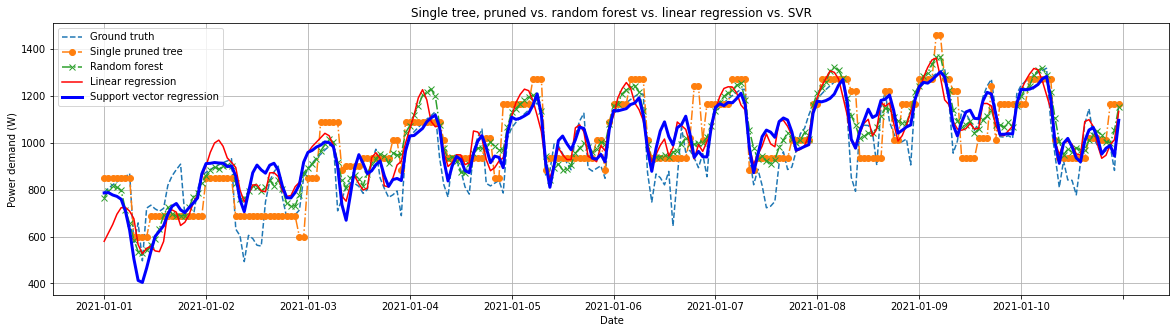

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(xaxis, y_test_m, label='Ground truth', linestyle='--')
plt.plot(xaxis, prediction_alphas[1], label='Single pruned tree', linestyle = '-.', marker = 'o')
plt.plot(xaxis, prediction_random_forest, label='Random forest', linestyle = '-.', marker = 'x')
plt.plot(xaxis, prediction_lreg, label='Linear regression', color='r')
plt.plot(xaxis, prediction_svr, label='Support vector regression', linewidth=3, color='b')
plt.title('Single tree, pruned vs. random forest vs. linear regression vs. SVR')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Power demand (W)")
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

In [ ]:
print("Pruned single tree: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))
print("Random forest: \t \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_forest)*100), mean_squared_error(y_test_m, prediction_random_forest)))
print("Boosting: \t \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_boost)*100), mean_squared_error(y_test_m, prediction_boost)))
print("Linear regression: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))
print("Lasso regression: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lassoreg)*100), mean_squared_error(y_test_m, prediction_lassoreg)))
print("Support vector regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_svr)*100), mean_squared_error(y_test_m, prediction_svr)))

Pruned single tree: 	 	 R² = 54.75 % and MSE = 23140.49 Watts
Bagging: 	 	 	 R² = 67.92 % and MSE = 10853.97 Watts
Random patches: 	 	 R² = 68.97 % and MSE = 10497.66 Watts
Random forest: 	 	 	 R² = 69.54 % and MSE = 10305.77 Watts
Boosting: 	 	 	 R² = 61.49 % and MSE = 13027.29 Watts
Linear regression: 	 	 R² = 68.15 % and MSE = 10776.49 Watts
Lasso regression: 	 	 R² = 68.72 % and MSE = 10581.54 Watts
Support vector regression: 	 R² = 69.13 % and MSE = 10441.88 Watts


In [ ]:
SVRreg_results = []
for k in range(numdays):
    
  # One-step ahead forecast, repeated for the length of the test vector
  x_train_moving = inp.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  y_train_moving = out.iloc[start_day + k * testlen : start_day + trainlen + k * testlen]
  SVRreg.fit(x_train_moving, y_train_moving)
  x_test = X_test_m.iloc[k * testlen : k * testlen + testlen].copy()
  SVRreg_results.append(SVRreg.predict(x_test.to_numpy()) )  
   
xresults = [[i+j*24 for i in range(len(SVRreg_results[0]))] for j in range(len(SVRreg_results))]
xtesting = [i for i in range(len(y_test_m))]
global_results = [item for sublist in SVRreg_results for item in sublist]
SVRreg_cvrmse = truncate(cvrmse(global_results, y_test_m), 3)

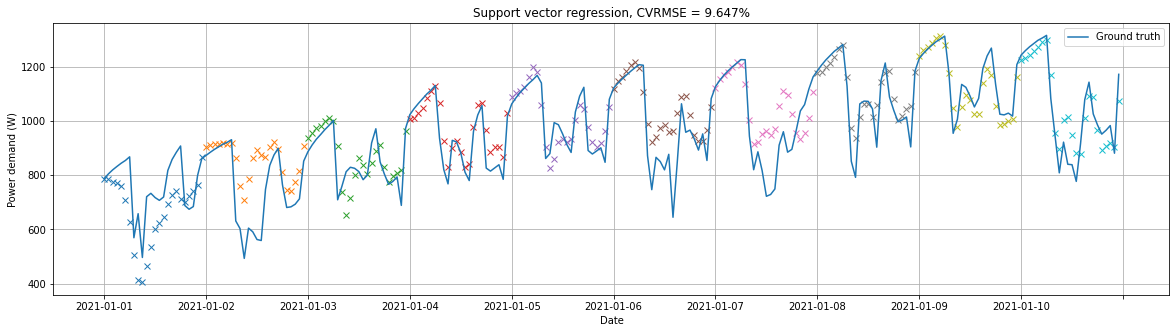

In [ ]:
plt.figure(figsize=(20, 5))
plt.xlabel("Date")
plt.ylabel("Power demand (W)")

for i in range(len(SVRreg_results)):
    
    plt.plot(xresults[i], SVRreg_results[i], 'x')
plt.plot(xtesting, y_test_m, label='Ground truth')
plt.title('Support vector regression, CVRMSE = '+str(SVRreg_cvrmse)+"%")
plt.legend()
plt.xticks(ticks=[i*24 for i in range(11)], labels=testxlabels)

plt.grid()
plt.show()

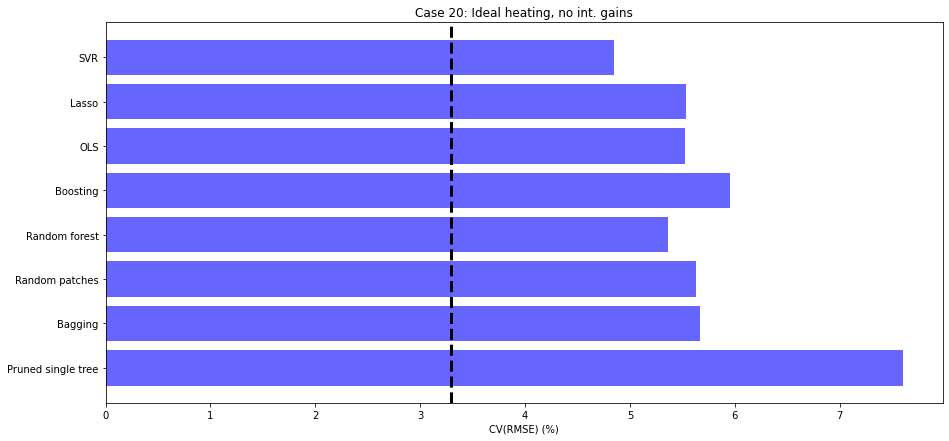

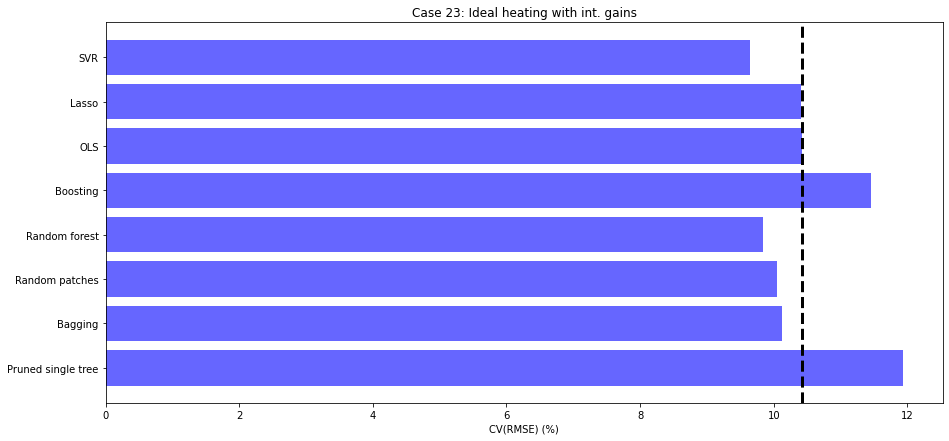

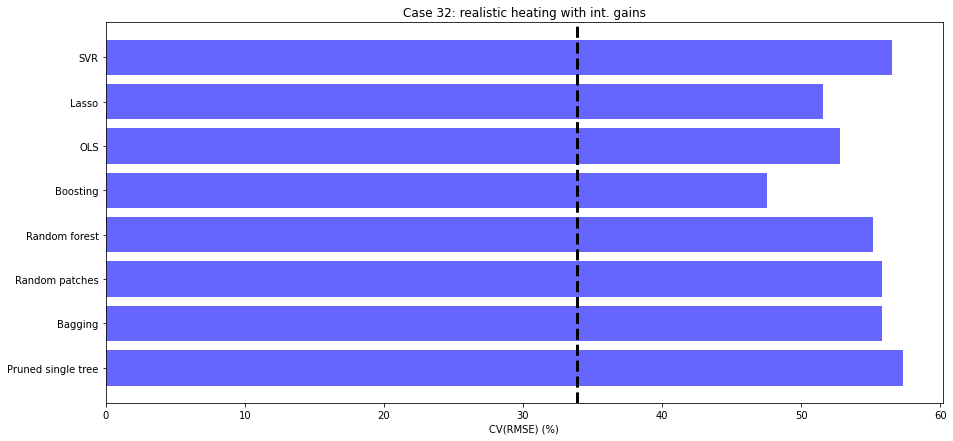

In [ ]:
methods = ["Pruned single tree", "Bagging", "Random patches", "Random forest", "Boosting", "OLS", "Lasso", "SVR"]
moving   = [
            [7.60, 5.67, 5.63, 5.36, 5.95, 5.52, 5.53, 4.85],
            [11.93, 10.12, 10.05, 9.84, 11.45, 10.43, 10.41, 9.64],
            [57.30, 55.82, 55.83, 55.15, 47.56, 52.78, 51.60, 56.56]
            ]
baseline = [3.29, 10.43, 33.90]
case = ["Case 20: Ideal heating, no int. gains", "Case 23: Ideal heating with int. gains", "Case 32: realistic heating with int. gains"]

for i in range(len(case)):
  plt.figure(figsize=(15, 7))
  width = 0.8
  indices = np.arange(len(moving[0]))
  plt.barh(indices, moving[i], alpha = 0.6,
          color='b')
  plt.yticks(indices, methods)
  plt.axvline(x = baseline[i], color = 'black', ls = '--', lw = 3)
  plt.xlabel("CV(RMSE) (%)")
  plt.title(case[i])
  plt.show()

**This is all we have to show for today.** Next time, we will discuss Gaussian processes and Gaussian process regression as well as time series models with autoregression (ARX, ARMAX, ARIMAX, ...).